# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [13]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print "TensorFlow Version {}".format(tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow Version 1.3.0


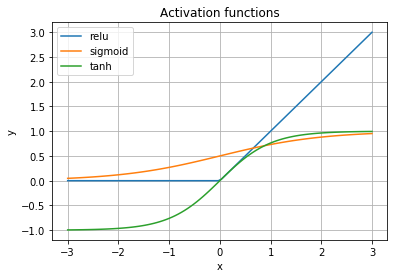

In [14]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [15]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [16]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    import os
    data_path = "data/cifar-10-batches-py"
    all_batches = []
    all_labels = []
    for b in range(1,6):
        f_train_curr = os.path.join(data_path, 'data_batch_%d' % (b, ))
        batch, labels = unpickle(f_train_curr)
        batch = batch.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        all_batches.append(batch)
        all_labels.append(labels)
    data_train = np.concatenate(all_batches)
    labels_train = np.concatenate(all_labels)
    del batch, labels
    data_val = data_train[range(num_training, num_training+num_validation)]
    labels_val = labels_train[range(num_training, num_training+num_validation)]
    data_train = data_train[range(num_training)]
    labels_train = labels_train[range(num_training)]

    seq = range(num_training)
    np.random.shuffle(seq)
    data_train = data_train[seq]
    labels_train = labels_train[seq]
    return data_train, labels_train, data_val, labels_val 
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    import os
    data_path = "data/cifar-10-batches-py"
    f_test = os.path.join(data_path, 'test_batch')
    data_test, labels_test = unpickle(f_test)
    data_test = data_test.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    return data_test, np.array(labels_test)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [20]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def conv2d_wd(input, kernel_size, stride, num_filter, weight_decay):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]
    
    init_val = np.sqrt(2.0/(kernel_size*kernel_size*input.get_shape().as_list()[3]))
    W = tf.get_variable('W', filter_shape, tf.float32, tf.random_normal_initializer(0.0, init_val))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    weight_loss = tf.multiply(tf.nn.l2_loss(W), weight_decay, name='weight_loss')
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, weight_loss)
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def weight_variable(shape, weight_decay):
    """weight_variable generates a weight variable of a given shape."""
    init_val = np.sqrt(2.0/shape[0])
    W = tf.get_variable("W", shape, tf.float32, tf.random_normal_initializer(0.0, init_val))
    weight_loss = tf.multiply(tf.nn.l2_loss(W), weight_decay, name='weight_loss')
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, weight_loss)
    return W

def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    b = tf.get_variable(name="b", shape=shape, initializer=tf.zeros_initializer())
    return b

def convBnRelu(input, kernel_size, stride, num_filter, weight_decay, is_train):
    conv = conv2d_wd(input, kernel_size, stride, num_filter, weight_decay)
    bn = tf.contrib.layers.batch_norm(conv, center=True, scale=True, is_training=is_train)
    relu = tf.nn.relu(bn)
    return relu

def avg_pool(input, kernel_size, stride, padding = 'SAME'):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.avg_pool(input, ksize=ksize, strides=strides, padding=padding)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [21]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, kernel_size = 5, stride = 1, num_filter = 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, kernel_size = 3, stride = 2)           
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.reshape(self.pool2, [-1, 8*8*64])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = tf.contrib.layers.fully_connected(self.flat, 384)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.fc3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = tf.contrib.layers.fully_connected(self.fc3, 10, activation_fn = None)          
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = 0.2
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        #Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
        global_step = tf.Variable(0, trainable=False)
        learning_rate =  tf.train.exponential_decay(5e-4, global_step, 500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op)        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_, self.is_train: 1}                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            #def average(arr, n):
            #    start = len(arr) % n
            #    part = np.mean(np.array(arr[start:]).reshape(-1, n), 1)
            #    if start != 0:
            #        part = np.append(np.array(sum(arr[:start])) / start, part)
            #    return part
            #average_len = 100
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            #loss_hist_ = average(losses, average_len) # sparse the curve a bit
            plt.plot(losses)
            plt.xlabel('Iteration')
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            #accuracy_hist_ = average(accuracies, average_len)
            plt.title('Training Accuracy')
            plt.plot(accuracies)
            plt.xlabel('Iteration')
            plt.gcf().set_size_inches(15, 12)
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_, self.is_train: 0}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 31.209, accuracy = 0.117
iteration (50): loss = 2.050, accuracy = 0.250
iteration (100): loss = 1.751, accuracy = 0.398
iteration (150): loss = 1.637, accuracy = 0.445
iteration (200): loss = 1.611, accuracy = 0.453
iteration (250): loss = 1.685, accuracy = 0.383
iteration (300): loss = 1.455, accuracy = 0.414
iteration (350): loss = 1.544, accuracy = 0.398


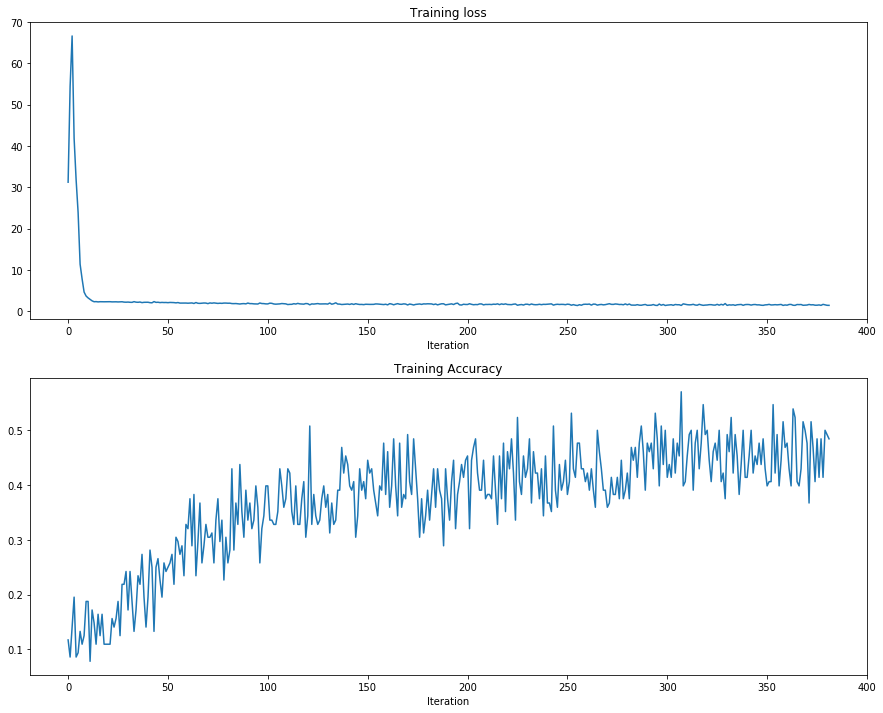

validation for epoch 0
-  epoch 0: validation accuracy = 0.499
train for epoch 1
iteration (400): loss = 1.493, accuracy = 0.469
iteration (450): loss = 1.326, accuracy = 0.508
iteration (500): loss = 1.443, accuracy = 0.484
iteration (550): loss = 1.418, accuracy = 0.539
iteration (600): loss = 1.444, accuracy = 0.555
iteration (650): loss = 1.382, accuracy = 0.508
iteration (700): loss = 1.231, accuracy = 0.602
iteration (750): loss = 1.155, accuracy = 0.586


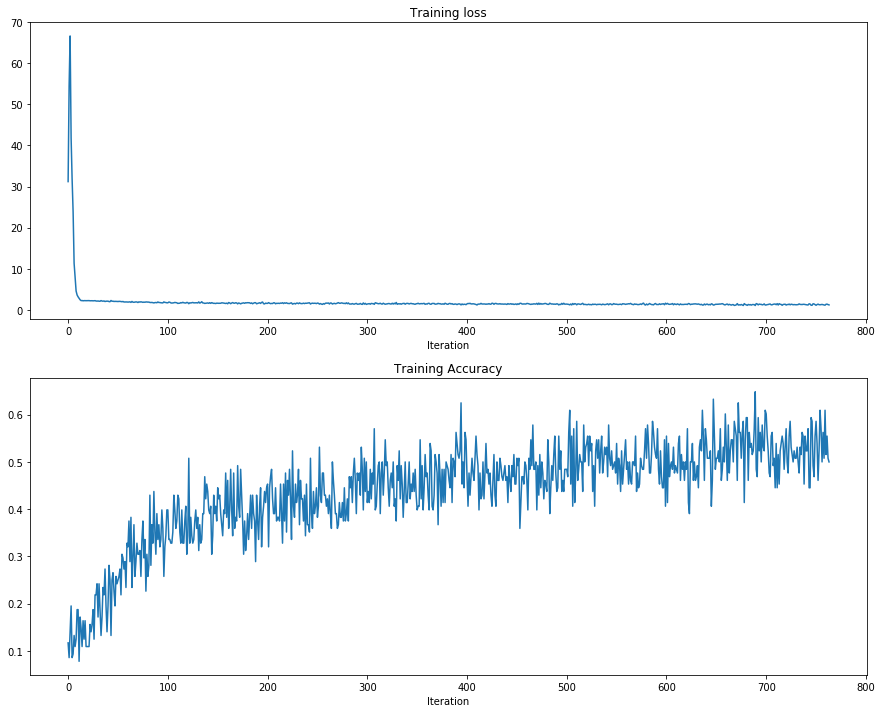

validation for epoch 1
-  epoch 1: validation accuracy = 0.574
train for epoch 2
iteration (800): loss = 1.309, accuracy = 0.562
iteration (850): loss = 1.259, accuracy = 0.555
iteration (900): loss = 1.245, accuracy = 0.516
iteration (950): loss = 1.359, accuracy = 0.484
iteration (1000): loss = 1.211, accuracy = 0.523
iteration (1050): loss = 1.036, accuracy = 0.695
iteration (1100): loss = 1.307, accuracy = 0.531


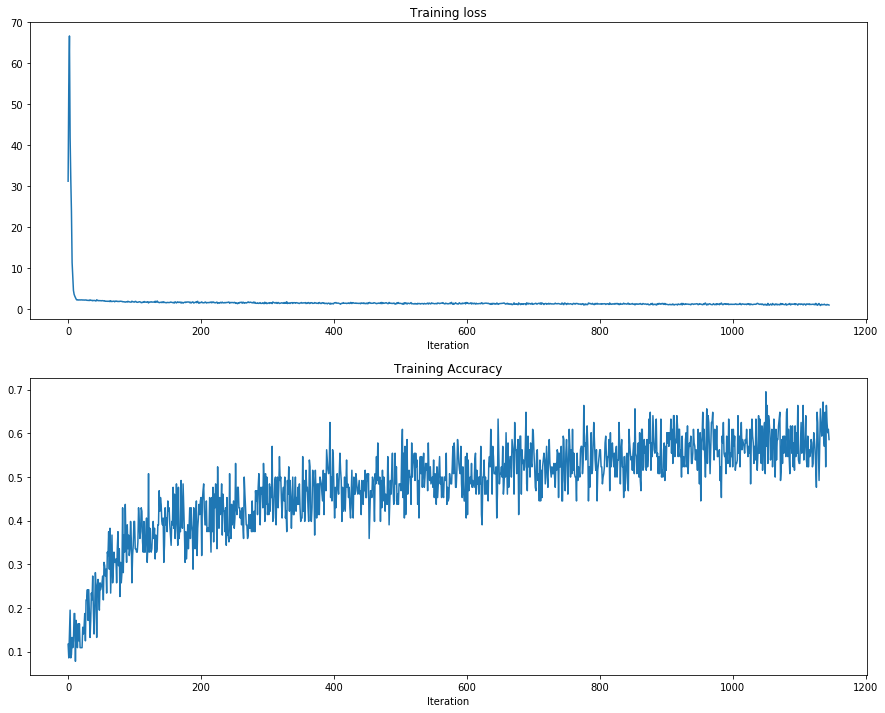

validation for epoch 2
-  epoch 2: validation accuracy = 0.604
train for epoch 3
iteration (1150): loss = 0.971, accuracy = 0.625
iteration (1200): loss = 1.050, accuracy = 0.602
iteration (1250): loss = 1.156, accuracy = 0.609
iteration (1300): loss = 1.060, accuracy = 0.672
iteration (1350): loss = 1.099, accuracy = 0.633
iteration (1400): loss = 0.955, accuracy = 0.656
iteration (1450): loss = 1.096, accuracy = 0.633
iteration (1500): loss = 1.123, accuracy = 0.609


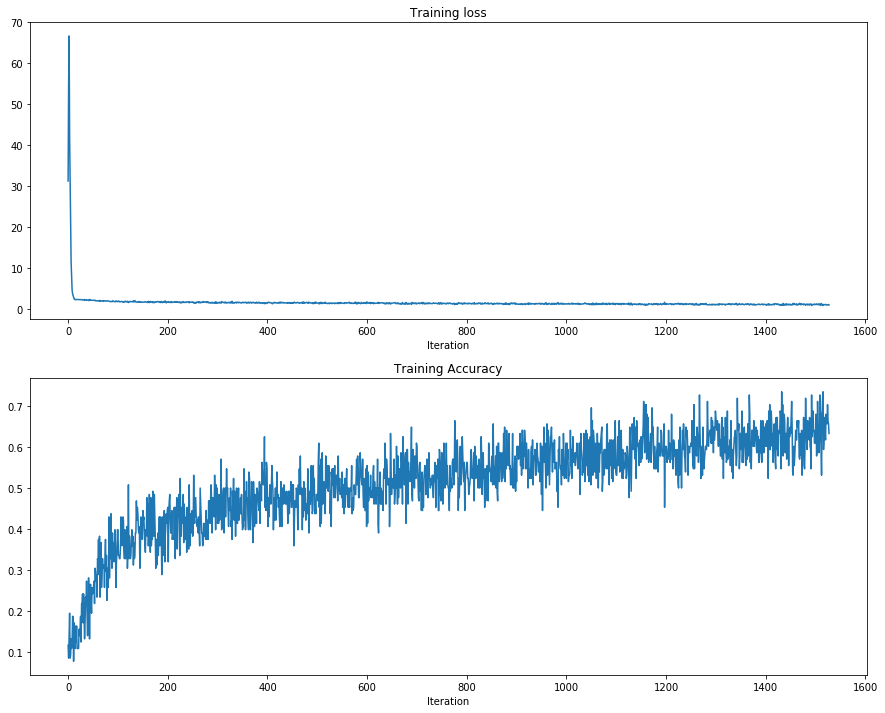

validation for epoch 3
-  epoch 3: validation accuracy = 0.624
train for epoch 4
iteration (1550): loss = 1.009, accuracy = 0.656
iteration (1600): loss = 1.033, accuracy = 0.594
iteration (1650): loss = 1.071, accuracy = 0.641
iteration (1700): loss = 0.915, accuracy = 0.641
iteration (1750): loss = 0.919, accuracy = 0.727
iteration (1800): loss = 1.085, accuracy = 0.680
iteration (1850): loss = 1.119, accuracy = 0.680
iteration (1900): loss = 0.911, accuracy = 0.711


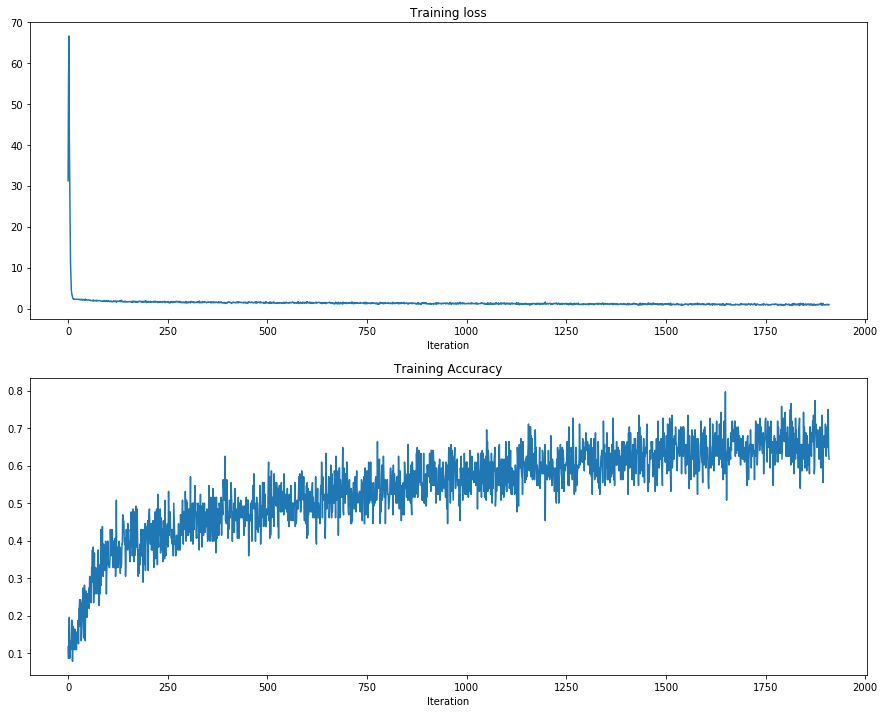

validation for epoch 4
-  epoch 4: validation accuracy = 0.628
***** test accuracy: 0.594
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [9]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    #with tf.device('/cpu:0'):
    model = BaseModel()
    model.train(sess, X_train, Y_train, X_val, Y_val)
    accuracy = model.evaluate(sess, X_test, Y_test)
    print('***** test accuracy: %.3f' % accuracy)
    saver = tf.train.Saver()
    model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
    print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [22]:
import numpy as np
from IPython.display import clear_output, Image, display, HTML

In [23]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [24]:
# first try is to add more layers to the base model, achieve 80% accuracy when converge
# second try is a vgg model, achieve 84% accuracy with 50 epoches, very slow
# it is the third try, the nin model, achieve over 80% accuracy within 25 epoches
# I always keep the validation data out of from training
# Please make sure you are connected to the internet. It is going to render the network by cloud!
# Please make sure you have enough memory and disk space. It will save the best model during training!

class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 100

    def _input_ops(self):
        # Placeholders

        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        self.is_train = tf.placeholder(tf.bool)
        
        self.keep_prob = 0.5
        self.weight_decay = 1e-4

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################
        print('intput layer: ' + str(self.X.get_shape()))

        w_X = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), self.X)
        aw_X = tf.map_fn(lambda frame: tf.image.random_flip_left_right(frame), w_X)
        fw_X = tf.cond(self.is_train, lambda : aw_X, 
                                      lambda : w_X)#close data augmentation when eval
        with tf.variable_scope('nin_1'):
            with tf.variable_scope('l1_conv1'):
                conv1_1 = convBnRelu(fw_X, kernel_size = 5, stride = 1, num_filter = 192, 
                                     weight_decay = self.weight_decay, is_train = self.is_train)
            with tf.variable_scope('l1_conv2'):
                conv1_2 = convBnRelu(conv1_1, kernel_size = 1, stride = 1, num_filter = 160, 
                                     weight_decay = self.weight_decay, is_train = self.is_train)
            with tf.variable_scope('l1_conv3'):
                conv1_3 = convBnRelu(conv1_2, kernel_size = 1, stride = 1, num_filter = 96, 
                                     weight_decay = self.weight_decay, is_train = self.is_train)
            pool1 = max_pool(conv1_3, kernel_size = 3, stride = 2)
            cnn_drop1 = tf.layers.dropout(pool1, rate = self.keep_prob, training = self.is_train)
            print('nin1 layer: ' + str(cnn_drop1.get_shape()))

        with tf.variable_scope('nin_2'):
            with tf.variable_scope('l2_conv1'):
                conv2_1 = convBnRelu(cnn_drop1, kernel_size = 5, stride = 1, num_filter = 192, 
                                     weight_decay = self.weight_decay, is_train = self.is_train)
            with tf.variable_scope('l2_conv2'):
                conv2_2 = convBnRelu(conv2_1, kernel_size = 1, stride = 1, num_filter = 192, 
                                     weight_decay = self.weight_decay, is_train = self.is_train)
            with tf.variable_scope('l2_conv3'):
                conv2_3 = convBnRelu(conv2_2, kernel_size = 1, stride = 1, num_filter = 192, 
                                     weight_decay = self.weight_decay, is_train = self.is_train)
            pool2 = avg_pool(conv2_3, kernel_size = 3, stride = 2)
            cnn_drop2 = tf.layers.dropout(pool2, rate = self.keep_prob, training = self.is_train)
            print('nin2 layer: ' + str(pool2.get_shape()))

        with tf.variable_scope('nin_3'):
            with tf.variable_scope('l3_conv1'):
                conv3_1 = convBnRelu(cnn_drop2, kernel_size = 3, stride = 1, num_filter = 192, 
                                     weight_decay = self.weight_decay, is_train = self.is_train)
            with tf.variable_scope('l3_conv2'):
                conv3_2 = convBnRelu(conv3_1, kernel_size = 1, stride = 1, num_filter = 192, 
                                     weight_decay = self.weight_decay, is_train = self.is_train)
            with tf.variable_scope('l3_conv3'):
                conv3_3 = convBnRelu(conv3_2, kernel_size = 1, stride = 1, num_filter = 10, 
                                     weight_decay = self.weight_decay, is_train = self.is_train)
            pool3 = avg_pool(conv3_3, kernel_size = 8, stride = 1, padding = 'VALID')
            print('nin3 layer: ' + str(pool3.get_shape()))
        
        flat = tf.reshape(pool3, [-1, 10])
        # Return the last layer
        return flat
    def _loss(self, labels, logits):
        self.wd_loss = tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        self.ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits = logits))
        self.loss_op = self.ce_loss + self.wd_loss
        
        
    def _build_optimizer(self):
        #Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.97
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            global_step = tf.Variable(0, trainable=False)
            learning_rate =  tf.train.exponential_decay(1e-3, global_step, 500, 0.97, staircase=True)
            self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op) 

    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        step = 0
        losses = []
        accuracies = []
        val_accs = []
        max_val_acc = 0.0
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            seq = range(num_training)
            np.random.shuffle(seq)
            X_train = X_train[seq]
            Y_train = Y_train[seq]
            epoch_loss = 0.0
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {self.X: X_, self.Y: Y_, self.is_train: 1}                
                fetches = [self.train_op, self.loss_op, self.ce_loss, self.wd_loss, self.accuracy_op]

                _, loss, ce_loss, wd_loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)
                epoch_loss += loss
                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f, ce = %.3f, wd = %.3f' %
                        (step, loss, accuracy, ce_loss, wd_loss))
                step += 1
            # Print validation results
            print('total loss for epoch %d: %.3f' % (epoch, epoch_loss))
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            val_accs.append(val_accuracy)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            if val_accuracy > max_val_acc and val_accuracy > 0.8:
                print "meet better model, save model..."
                max_val_acc = val_accuracy
                saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        
        print('recover the best model with expected validation accuracy: %.3f' % max_val_acc)
        saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        
        # Graph 1. X: epoch, Y: training loss
        plt.subplot(3, 1, 1)
        plt.title('Training loss')
        plt.plot(losses)
        plt.xlabel('Iteration')
        # Graph 2. X: epoch, Y: training accuracy
        plt.subplot(3, 1, 2)
        plt.title('Training Accuracy')
        plt.plot(accuracies)
        plt.xlabel('Iteration')
        # Graph 2. X: epoch, Y: training accuracy
        plt.subplot(3, 1, 3)
        plt.title('Validation Accuracy')
        plt.plot(val_accs)
        plt.xlabel('Iteration')
        plt.tight_layout()
        plt.gcf().set_size_inches(15, 12)
        plt.show()
    #############################################################################
    # TODO: You can redefine BaseModel's methods                                #
    #############################################################################

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

In [25]:
#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
X_train_ = X_train 
X_val_ =  X_val 
X_test_ =  X_test 
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [26]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

model = YourModel()

show_graph(tf.get_default_graph())

-----  Your model  -----
intput layer: (?, 32, 32, 3)
nin1 layer: (?, 16, 16, 96)
nin2 layer: (?, 8, 8, 192)
nin3 layer: (?, 1, 1, 10)


-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.456, accuracy = 0.109, ce = 2.314, wd = 0.142
iteration (50): loss = 1.837, accuracy = 0.484, ce = 1.695, wd = 0.142
iteration (100): loss = 1.754, accuracy = 0.477, ce = 1.613, wd = 0.141
iteration (150): loss = 1.578, accuracy = 0.586, ce = 1.437, wd = 0.140
iteration (200): loss = 1.565, accuracy = 0.555, ce = 1.426, wd = 0.139
iteration (250): loss = 1.526, accuracy = 0.586, ce = 1.387, wd = 0.139
iteration (300): loss = 1.433, accuracy = 0.625, ce = 1.294, wd = 0.138
iteration (350): loss = 1.436, accuracy = 0.602, ce = 1.299, wd = 0.137
total loss for epoch 0: 626.808
validation for epoch 0
-  epoch 0: validation accuracy = 0.129
train for epoch 1
iteration (400): loss = 1.389, accuracy = 0.633, ce = 1.252, wd = 0.137
iteration (450): loss = 1.212, accuracy = 0.719, ce = 1.075, wd = 0.137
iteration (500): loss = 1.312, accuracy = 0.688, ce = 1.176, wd = 0.137
iteration (550): loss = 1.292, accuracy = 0.703, ce

INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt


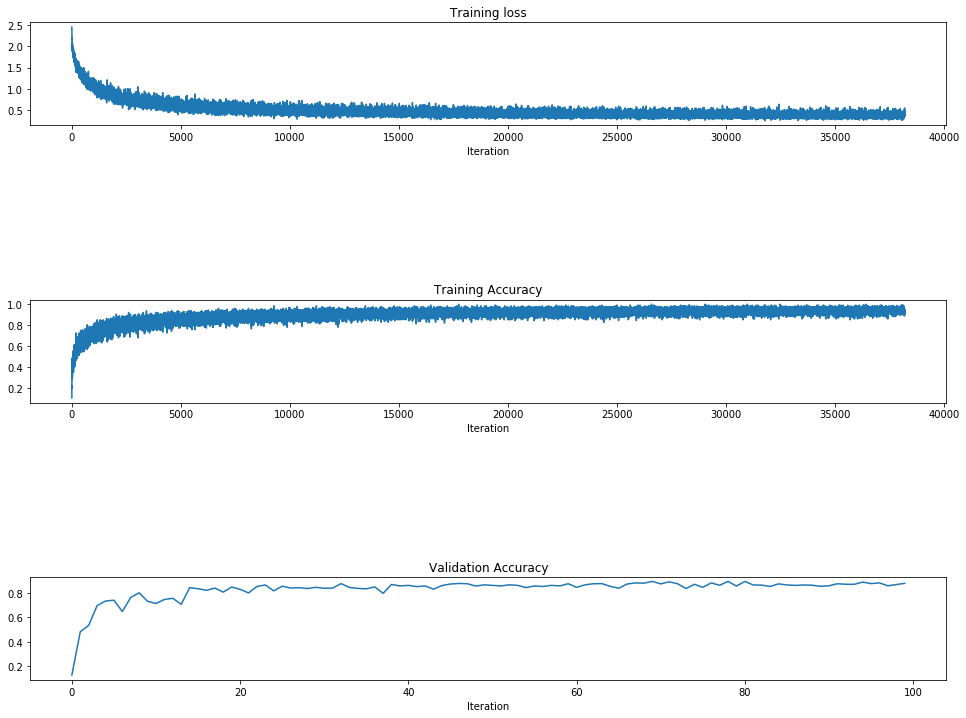

***** test accuracy: 0.874
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [27]:
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

In [43]:
sess.close()

In [ ]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

In [ ]:
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)
sess.close()